In [2]:
pip install emcee corner

     ---------------------------------------- 47.4/47.4 kB 1.2 MB/s eta 0:00:00


[notice] A new release of pip available: 22.1.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:06<00:00, 639.24it/s]


Best-fit values (median of posterior): a = -0.008 ± 0.001, b = 3.723 ± 0.317, c = 17.656 ± 26.922


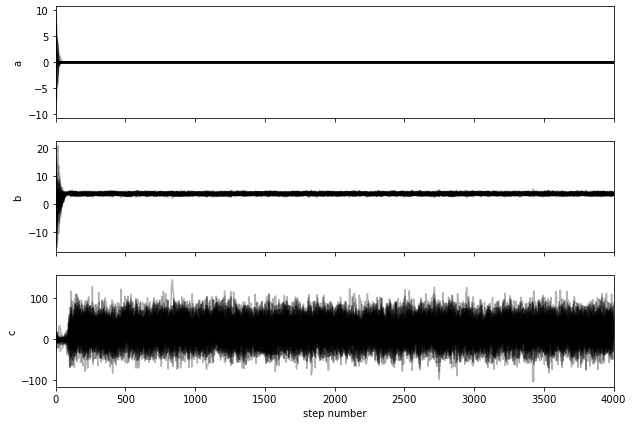

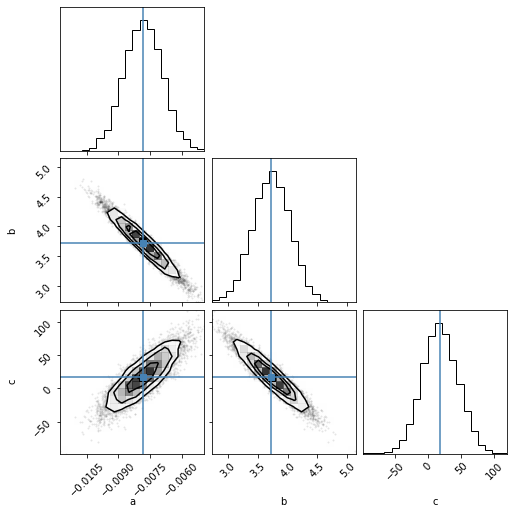

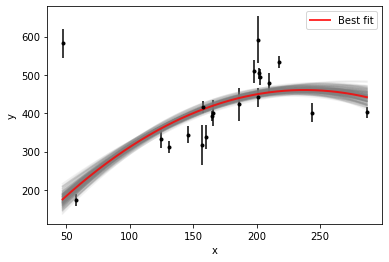

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import requests

# Step 1: Load the data
url = "https://theory.tifr.res.in/~kulkarni/data.txt"
data = np.loadtxt(requests.get(url).content.decode('utf-8').splitlines(), skiprows=4)
measurement_number, x, y, sigma_y = data.T

# Step 2: Define the model and log-probability function
def model(theta, x):
    a, b, c = theta
    return a * x**2 + b * x + c

def log_likelihood(theta, x, y, sigma_y):
    model_y = model(theta, x)
    sigma2 = sigma_y**2
    return -0.5 * np.sum((y - model_y)**2 / sigma2 + np.log(2 * np.pi * sigma2))

# def log_prior(theta):
#     a, b, c = theta
#     if -1000.0 < a < 1000.0 and -1000.0 < b < 1000.0 and -1000< c <1000:
#         return 0.0
#     return -np.inf

def log_prior(theta):
    return 0

def log_probability(theta, x, y, sigma_y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, sigma_y)

# Step 3: Set up the MCMC sampler
ndim = 3  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nsteps = 4000  # number of MCMC steps

# Initial positions for the walkers
pos = np.random.uniform(-10, 10, (nwalkers, ndim))

# Initialize the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, sigma_y))

# Step 4: Run the MCMC sampler
sampler.run_mcmc(pos, nsteps, progress=True)

# Step 5: Analyze the results
samples = sampler.get_chain(discard=2000, thin=15, flat=True)
a_mcmc, b_mcmc, c_mcmc = np.percentile(samples, 50, axis=0)
a_sigma, b_sigma, c_sigma = np.std(samples, axis=0)

print(f"Best-fit values (median of posterior): a = {a_mcmc:.3f} ± {a_sigma:.3f}, b = {b_mcmc:.3f} ± {b_sigma:.3f}, c = {c_mcmc:.3f} ± {c_sigma:.3f}")

# Step 6: Plot the results
# Plot the chains
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
labels = ["a", "b", "c"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.get_chain()[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, nsteps)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("step number")
plt.savefig('chains.png')
plt.show()

# Corner plot of the posterior distributions
fig = corner.corner(samples, labels=labels, truths=[a_mcmc, b_mcmc, c_mcmc])
plt.savefig('corner_plot.png')
plt.show()

# Plot the data with the best-fit model and 200 models randomly chosen from the posterior
plt.errorbar(x, y, yerr=sigma_y, fmt=".k", capsize=0)
x0 = np.linspace(min(x), max(x), 1000)
for theta in samples[np.random.randint(len(samples), size=200)]:
    plt.plot(x0, model(theta, x0), color="gray", alpha=0.1)
plt.plot(x0, model([a_mcmc, b_mcmc, c_mcmc], x0), color="red", lw=2, alpha=0.8, label="Best fit")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.savefig('best_fit.png')
plt.show()
